# Pengenalan Convolutional Neural Network

## Definisi CNN
Convolutional Neural Network (CNN) adalah jenis arsitektur jaringan saraf tiruan yang dirancang khusus untuk memproses data grid, seperti gambar atau citra. CNN sangat efektif dalam tugas-tugas pengenalan pola visual karena mampu mengekstrak fitur hierarkis dari data input. 

Dalam hal Pembelajaran Mesin, Artificial Neural Network (ANN) atau Jaringan Syaraf Tiruan bekerja dengan sangat baik. ANN digunakan dalam berbagai dataset seperti citra, audio, dan teks. Berbagai jenis ANN digunakan untuk tujuan yang berbeda, misalnya untuk memprediksi urutan kata, kami menggunakan Recurrent Neural Network (RNN), lebih tepatnya LSTM, dan juga untuk klasifikasi citra, kami menggunakan CNN.

Dalam ANN biasa ada tiga jenis layer:
1. Input layer: layer ini tempat kita memberikan input ke model kita. Jumlah neuron di layer ini sama dengan jumlah total fitur dalam data kita (jumlah piksel dalam kasus citra).
1. Hidden layer (HL): Masukan dari layer Input kemudian dimasukkan ke dalam HL. Banyaknya HL tergantung pada model dan ukuran data kita. Setiap HL dapat memiliki jumlah neuron yang berbeda. Output dari setiap layer dihitung dengan perkalian matriks dari output layer sebelumnya dengan bobot yang dapat dilatih dari layer tersebut dan kemudian dengan penambahan bias yang diikuti dengan fungsi aktivasi yang membuat jaringan menjadi nonlinier.
1. Output layer: Output dari HL kemudian dimasukkan ke dalam fungsi aktivasi seperti seperti sigmoid atau softmax yang mengubah output dari setiap kelas menjadi nilai probabilitas setiap kelas.

CNN adalah versi lanjutan dari ANN yang sebagian besar digunakan untuk mengekstrak fitur dari kumpulan data matriks seperti citra atau video. Berikut adalah contoh dari arsitektur sederhana dari CNN.
![Arsitektur sederhana CNN](arsitekturcnn.jpg "Arsitektur sederhana CNN")

Lapisan Convolutional menerapkan filter pada gambar input untuk mengekstrak fitur, lapisan Pooling melakukan downsampling pada gambar untuk mengurangi komputasi, dan lapisan yang terhubung penuh membuat prediksi akhir. Jaringan mempelajari filter yang optimal melalui backpropagation dan gradient descent.

In [32]:
import h5py
import os
from tqdm import tqdm
import cv2
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import glob
from torch.utils.data import DataLoader
import seaborn as sns

In [33]:
training_folder_name = 'dataset/leaves'

img_size = (128,128)
classes = sorted(os.listdir(training_folder_name))

labels = []
counter = 0
for file in classes:
    
    labels.append(file)
    counter += 1
sub_folders = classes # Insert your classes here
# labels = [0, 1]
# print(labels, sub_folders)
data = []
for sub, label in zip(sub_folders, labels):
    for file in os.listdir(os.path.join(training_folder_name,sub)):
        data.append((os.path.join(sub,file), label))

df = pd.DataFrame(data, columns=['file_names','labels'])

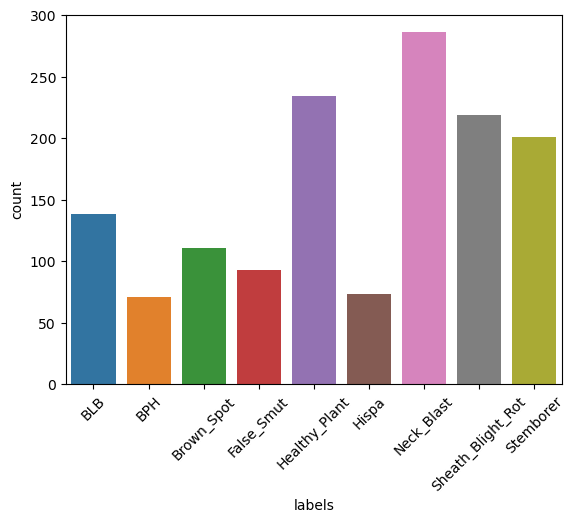

In [34]:

g = sns.countplot(data = df, x = 'labels');
g = g.set_xticklabels(labels=labels, rotation=45)

In [35]:
def load_dataset(data_path, sampler = None):
    import torch
    import torchvision
    import torchvision.transforms as transforms
    # Load all the images
    transformation = transforms.Compose([
        # Randomly augment the image data
            # Random horizontal flip
        transforms.Resize(128),
        transforms.RandomHorizontalFlip(0.5),
            # Random vertical flip
        transforms.RandomVerticalFlip(0.3),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    
    # use torch.utils.data.random_split for training/test split
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        sampler=sampler,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        sampler=sampler,
        shuffle=False
    )
        
    return train_loader, test_loader


# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(training_folder_name)
batch_size = train_loader.batch_size

print("Data loaders ready to read", training_folder_name)

Data loaders ready to read dataset/leaves


In [36]:
class LeafDataset(Dataset):
    def __init__(self):
        self.data, self.label = load_data()

    def __getitem__(self, item):
        images = self.data[item]
        label = self.label[item]
        return images, label

    def __len__(self):
        return self.data.shape[0]

In [37]:
class MySimpleCNN(nn.Module):
    def __init__(self, num_classes = 3):
        super(MySimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size =3, stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(24)
        
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(48)
        
        self.conv5 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, padding=2)
        self.bn5 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(in_features=1600, out_features=128)
        self.drop = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=num_classes)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.pool(x)
        
        x = self.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool(x)
        
        x = self.relu(self.conv3(x))
        x = self.bn3(x)
        x = self.pool(x)
        
        x = self.relu(self.conv4(x))
        x = self.bn4(x)
        x = self.pool(x)
        
        x = self.relu(self.conv5(x))
        x = self.bn5(x)
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.relu(self.fc1(x))
        x = self.drop(x)
        x = self.relu(self.fc2(x))
        
        x = self.fc3(x)
        
        return torch.log_softmax(x, dim=1)
        
        
            

In [38]:
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

# Create an instance of the model class and allocate it to the device
model = MySimpleCNN(len(classes)).to(device)

print(model)

MySimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (drop): 

In [39]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [40]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss


In [41]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 20
print('Training on', device)
for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss = test(model, device, test_loader)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Training on cuda
Epoch: 1
	Training batch 1 Loss: 2.234747
	Training batch 2 Loss: 4.228261
	Training batch 3 Loss: 3.469232
	Training batch 4 Loss: 2.274811
	Training batch 5 Loss: 2.640947
	Training batch 6 Loss: 2.166789
	Training batch 7 Loss: 2.092140
	Training batch 8 Loss: 2.311278
	Training batch 9 Loss: 2.256257
	Training batch 10 Loss: 1.998820
	Training batch 11 Loss: 2.108976
	Training batch 12 Loss: 1.887888
	Training batch 13 Loss: 1.957294
	Training batch 14 Loss: 2.283154
	Training batch 15 Loss: 2.012001
	Training batch 16 Loss: 1.944291
	Training batch 17 Loss: 2.042320
	Training batch 18 Loss: 1.750455
	Training batch 19 Loss: 1.915732
	Training batch 20 Loss: 2.183157
Training set: Average loss: 2.287928
Validation set: Average loss: 2.261127, Accuracy: 99/428 (23%)

Epoch: 2
	Training batch 1 Loss: 2.177576
	Training batch 2 Loss: 2.233358
	Training batch 3 Loss: 2.036121
	Training batch 4 Loss: 2.083059
	Training batch 5 Loss: 1.994869
	Training batch 6 Loss: 2.20

	Training batch 12 Loss: 1.170569
	Training batch 13 Loss: 1.318057
	Training batch 14 Loss: 1.334980
	Training batch 15 Loss: 1.268483
	Training batch 16 Loss: 1.360462
	Training batch 17 Loss: 1.698781
	Training batch 18 Loss: 1.098696
	Training batch 19 Loss: 1.404593
	Training batch 20 Loss: 1.332670
Training set: Average loss: 1.401715
Validation set: Average loss: 1.450050, Accuracy: 194/428 (45%)

Epoch: 12
	Training batch 1 Loss: 1.419208
	Training batch 2 Loss: 1.337775
	Training batch 3 Loss: 1.413559
	Training batch 4 Loss: 1.523972
	Training batch 5 Loss: 1.658611
	Training batch 6 Loss: 1.535173
	Training batch 7 Loss: 1.402130
	Training batch 8 Loss: 1.441919
	Training batch 9 Loss: 1.138757
	Training batch 10 Loss: 1.369309
	Training batch 11 Loss: 1.588564
	Training batch 12 Loss: 1.197797
	Training batch 13 Loss: 1.154595
	Training batch 14 Loss: 1.428400
	Training batch 15 Loss: 1.325464
	Training batch 16 Loss: 1.363142
	Training batch 17 Loss: 1.377886
	Training bat